<a href="https://colab.research.google.com/github/AlexCEjs/DesafioNLP/blob/main/Desaf%C3%ADo_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío NLP



Responsable: CHICA ELIZALDE ALEX FABRICIO

El desafío a realizarse consiste en realizar un estudios exploratorio de 3 modelos en la tarea de clasificación de emociones (https://github.com/fmplaza/EmoEvent/tree/master/splits). Este dataset contiene 8409 tweets anotados con una de las siguientes categorías: anger, sadness, joy, disgust, fear, surprise, offensive, other. Además, los tweets están relacionados a eventos particulares encontrados en Twitter.

Los requerimientos son los siguientes:
* Deben explorar 3 modelos, pueden entrenar los propios (por ejemplo, una Red Neuronal Recurrente o una Sequence-to-Sequence), hacer fine-tuning (por ejemplo de Bert o T5) o usar un modelo ya listo (por ejemplo, GPT-4o). (9 puntos)
* Deben reportar los resultados por cada emoción (categoría) y también realizar un análisis por evento, matriz de confusión entre otras cosas que consideren pertinente. (5 puntos)
* Debe publicar lo desarrollado en un notebook disponible en GitHub. La entrega debe incluir solo el link al repositorio. (3 puntos)
* El notebook debe estar detallado en cada paso. (3 puntos)

# Introducción

Antes de iniciar con el preprocesamiento de los datos, se procede a instalar y verificar las versiones de las librerías principales que se utilizarán a lo largo del proyecto.
Esto permite asegurar la compatibilidad entre dependencias y garantizar la reproducibilidad de los experimentos. Entre los paquetes instalados se incluyen:

* **numpy y pandas**: manipulación y análisis de datos.
* **scikit-learn**: extracción de características y métricas de evaluación.
* **matplotlib y seaborn**: visualización de datos.
* **torch**: construcción y entrenamiento de redes neuronales.
* **transformers y sentencepiece**: modelos preentrenados de lenguaje natural (ej. BERT).
* **datasets y accelerate**: manejo eficiente de conjuntos de datos y optimización en entrenamiento.
* **tqdm**: monitoreo de progreso en operaciones iterativas.

In [10]:
%pip install --no-cache-dir \
  numpy==1.26.4 \
  pandas==2.2.2 \
  scikit-learn==1.5.1 \
  matplotlib==3.9.2 \
  seaborn==0.13.2 \
  torch==2.3.0 \
  transformers==4.44.2 \
  sentencepiece==0.2.0 \
  datasets==2.21.0 \
  accelerate==0.34.2 \
  tqdm==4.66.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 156.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import numpy as np, pandas as pd, sklearn, torch, transformers, matplotlib.pyplot as plt
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

numpy: 1.26.4
pandas: 2.2.2
sklearn: 1.5.1
torch: 2.3.0+cu121
transformers: 4.44.2


# PARTE 1: Carga y exploración inicial del dataset

En esta primera sección se procede a cargar el dataset EmoEvent directamente desde su repositorio en GitHub. Para garantizar una lectura robusta, se implementa una función de carga segura (`load_tsv`) que incluye manejo de excepciones y validación de las columnas esperadas en cada archivo (`train, dev, test`).

El dataset contiene información de tweets clasificados según:

* id: identificador único del tweet.
* event: evento o contexto asociado al tweet.
* tweet: texto del mensaje en español.
* offensive: indicador de si el tweet es ofensivo.
* emotion: etiqueta emocional asociada (`ej. anger, sadness, joy, fear, surprise, disgust, others`).

Posteriormente, se realizan chequeos exploratorios iniciales para evaluar la calidad de los datos:
Detección de valores nulos y duplicados.
Verificación de que las etiquetas de emoción coincidan con las categorías esperadas.
Revisión de la distribución de clases en cada partición del dataset.
Identificación de los eventos con mayor número de tweets.

Además, se genera una visualización de la distribución de emociones en el conjunto de entrenamiento, lo cual permite observar posibles desbalances de clases que pueden influir en el rendimiento de los modelos posteriores.

Finalmente, se comprueba la consistencia de los eventos entre los tres splits (`train, dev y test`) y se guardan muestras aleatorias en archivos locales (`sample_train.csv, sample_dev.csv, sample_test.csv`) para una inspección manual si fuese necesaria.

train cargado: 5723 filas, 5 columnas
dev cargado: 844 filas, 5 columnas
test cargado: 1656 filas, 5 columnas

=== TRAIN ===
Primeras filas:


,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness


Nulos por columna:
id           0
event        0
tweet        0
offensive    0
emotion      0
dtype: int64
Duplicados: id = 0 | tweet = 2
Clases encontradas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']

Distribución de clases (counts):
emotion
others      2800
joy         1227
sadness      693
anger        589
surprise     238
disgust      111
fear          65
Name: count, dtype: int64

Top 10 eventos (mayor número de tweets):
event
GameOfThrones      837
NotreDame          834
SpainElection      831
Venezuela          824
ChampionsLeague    813
WorldBookDay       775
GretaThunberg      416
LaLiga             393
Name: count, dtype: int64

=== DEV ===
Primeras filas:


,id,event,tweet,offensive,emotion
0,d23cfa8a-dad1-45b6-90eb-b786cd21e7d3,WorldBookDay,Ya que es el #DiaDelLibro hablemos de #cultura...,NO,sadness
1,5192574e-af5e-4ccb-aa1d-b801a9395b7f,GretaThunberg,♻️Nos arrepentiremos por no hacer nada porque ...,NO,others
2,86a2042d-4964-4e07-a02b-aa2953a86ced,Venezuela,El Sr Trump cree las mentiras que sus subordin...,NO,anger
3,067c0c3e-459e-4b36-8223-22d8ce7f9cd9,WorldBookDay,Pues como es el #DiaDelLibro con sus rosas y s...,NO,joy


Nulos por columna:
id           0
event        0
tweet        0
offensive    0
emotion      0
dtype: int64
Duplicados: id = 0 | tweet = 0
Clases encontradas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']

Distribución de clases (counts):
emotion
others      414
joy         181
sadness     104
anger        85
surprise     35
disgust      16
fear          9
Name: count, dtype: int64

Top 10 eventos (mayor número de tweets):
event
WorldBookDay       139
ChampionsLeague    126
GameOfThrones      124
NotreDame          123
SpainElection      119
Venezuela          113
GretaThunberg       56
LaLiga              44
Name: count, dtype: int64

=== TEST ===
Primeras filas:


,id,event,tweet,offensive,emotion
0,16b25dfb-e284-4a58-b62c-8186fc082eb6,GameOfThrones,"Señor de luz, ven a nosotros en nuestra oscuri...",NO,others
1,2a80f6bf-4750-4783-9bc8-fdb8ff2b94c4,SpainElection,Pues ya hemos votado tanto mi madre y yo #Elec...,NO,others
2,1f477a6f-3559-41ee-8ec5-2e77aee53190,WorldBookDay,"#DiaDelLibro 😇⭐❤️🙏🙌😍🌷 sentimientos, viajar con...",NO,joy
3,838add70-748c-4635-8133-36ff0b05aeb0,WorldBookDay,"¡Feliz #DíaDelLibro📚! ”El libro es fuerza, es ...",NO,joy


Nulos por columna:
id           30
event        30
tweet        30
offensive    30
emotion       0
dtype: int64
Duplicados: id = 29 | tweet = 29
Clases encontradas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']

Distribución de clases (counts):
emotion
others      814
joy         354
sadness     199
anger       168
surprise     67
disgust      33
fear         21
Name: count, dtype: int64

Top 10 eventos (mayor número de tweets):
event
WorldBookDay       240
Venezuela          234
ChampionsLeague    232
NotreDame          225
GameOfThrones      219
SpainElection      218
GretaThunberg      139
LaLiga             119
Name: count, dtype: int64


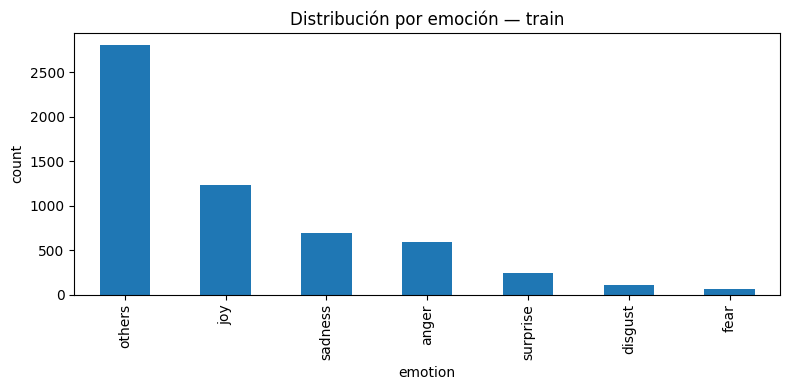


Eventos totales — train/dev/test: 8/8/9
Eventos presentes en las 3 particiones: 8. Ejemplos: ['LaLiga', 'GameOfThrones', 'SpainElection', 'WorldBookDay', 'NotreDame', 'Venezuela', 'ChampionsLeague', 'GretaThunberg']
Muestras guardadas: sample_train.csv, sample_dev.csv, sample_test.csv.


In [13]:
# carga del dataset
GITHUB_RAW_BASE = "https://raw.githubusercontent.com/fmplaza/EmoEvent/refs/heads/master/splits/es/"

TRAIN_URL = GITHUB_RAW_BASE + "train.tsv"
DEV_URL   = GITHUB_RAW_BASE + "dev.tsv"
TEST_URL  = GITHUB_RAW_BASE + "test.tsv"

# función segura de carga
def load_tsv(url, name):
    try:
        df = pd.read_csv(url, sep='\t', dtype={'id': str}, quoting=3,
                         encoding='utf-8', on_bad_lines='skip', low_memory=False)
    except Exception as e:
        print(f"Error cargando {name} desde:\n  {url}\nExcepción: {e}")
        return None
    expected = {'id','event','tweet','offensive','emotion'}
    missing = expected - set(df.columns)
    if missing:
        print(f"⚠️ Faltan columnas en {name}: {missing}. Columnas encontradas: {list(df.columns)}")
    print(f"{name} cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
    return df

train = load_tsv(TRAIN_URL, "train")
dev   = load_tsv(DEV_URL, "dev")
test  = load_tsv(TEST_URL, "test")

# si hay error en lectura, interrumpir
if any(v is None for v in (train, dev, test)):
    raise SystemExit("Carga incompleta — verificar bien la URL")

# Checks rapidos y summary
ALLOWED = {"anger","sadness","joy","disgust","fear","surprise","offensive","others"}

def quick_checks(df, name):
    print(f"\n=== {name.upper()} ===")
    print("Primeras filas:")
    display(df.head(4))
    print("Nulos por columna:")
    print(df.isna().sum())
    print("Duplicados: id =", df['id'].duplicated().sum(), "| tweet =", df['tweet'].duplicated().sum())
    uniques = sorted(df['emotion'].dropna().unique().tolist())
    print("Clases encontradas:", uniques)
    out = set(uniques) - ALLOWED
    if out:
        print("⚠️ Categorias fuera de lo esperado:", out)
    print("\nDistribución de clases (counts):")
    print(df['emotion'].value_counts())
    print("\nTop 10 eventos (mayor número de tweets):")
    print(df['event'].value_counts().head(10))

for n, d in [('train',train), ('dev',dev), ('test',test)]:
    quick_checks(d, n)

# Distribución de emociones en train
plt.figure(figsize=(8,4))
train['emotion'].value_counts().plot(kind='bar')
plt.title('Distribución por emoción — train')
plt.xlabel('emotion')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Eventos comunes entre splits
events_train = set(train['event'].unique())
events_dev   = set(dev['event'].unique())
events_test  = set(test['event'].unique())
events_all = events_train & events_dev & events_test

print(f"\nEventos totales — train/dev/test: {len(events_train)}/{len(events_dev)}/{len(events_test)}")
print(f"Eventos presentes en las 3 particiones: {len(events_all)}. Ejemplos: {list(events_all)[:10]}")

SEED = 42
# Guardar muestras para inspección de manera local
train.sample(5, random_state=SEED).to_csv('sample_train.csv', index=False)
dev.sample(5, random_state=SEED).to_csv('sample_dev.csv', index=False)
test.sample(5, random_state=SEED).to_csv('sample_test.csv', index=False)
print("Muestras guardadas: sample_train.csv, sample_dev.csv, sample_test.csv.")


# PARTE 2: Preprocesamiento de texto y representación con TF-IDF

Con el objetivo de preparar los datos para los modelos de clasificación, en esta sección se realiza un proceso de limpieza y transformación de los tweets.

**Limpieza de tweets**

Se define la función clean_tweet que aplica una serie de pasos de normalización:

* Conversión del texto a minúsculas.
* Sustitución de URLs, menciones y hashtags por tokens genéricos (`URL, USER, HASHTAG`).
* Eliminación de números, emojis y caracteres no ASCII.
* Supresión de signos de puntuación.
* Normalización de espacios en blanco.

De esta forma, los tweets quedan en un formato más homogéneo y adecuado para la vectorización.

**Representación con TF-IDF**

Posteriormente, se emplea un vectorizador TF-IDF (`TfidfVectorizer`) que transforma los tweets en representaciones numéricas, teniendo en cuenta la frecuencia relativa de cada término:

* Se utiliza un vocabulario limitado a 5000 términos más frecuentes.
* Se consideran tanto unigramas (palabras individuales) como bigramas (pares consecutivos de palabras).
* El vocabulario se construye únicamente a partir del conjunto de entrenamiento para evitar fuga de información.

Esto da como resultado tres matrices dispersas (`X_train_tfidf, X_dev_tfidf, X_test_tfidf`), que representan los tweets en los respectivos conjuntos de datos.

**Codificación de etiquetas**

Finalmente, las emociones se convierten a valores numéricos mediante LabelEncoder. Esto permite que los modelos de machine learning trabajen con las categorías de salida de manera eficiente. Las clases consideradas son:

* `anger, disgust, fear, joy, others, sadness, surprise, offensive`.

De esta forma, al concluir esta etapa, se cuenta con:

* Tweets preprocesados (`tweet_clean`).
* Representación vectorial mediante TF-IDF.
* Etiquetas codificadas listas para el entrenamiento de modelos.

In [3]:
import re
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Limpieza de tweets

def clean_tweet(text: str) -> str:
    text = str(text).lower()

    # remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text)

    # remover menciones y hashtags
    text = re.sub(r'@\w+', ' USER ', text)
    text = re.sub(r'#\w+', ' HASHTAG ', text)

    # remover números
    text = re.sub(r'\d+', ' NUM ', text)

    # remover emojis / caracteres no ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')

    # remover puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# aplicamos a cada split
for df in [train, dev, test]:
    df["tweet_clean"] = df["tweet"].apply(clean_tweet)

print("Ejemplos después de limpieza:")
display(train[["tweet", "tweet_clean"]].head(5))

# Tokenización clásica con TF-IDF
#
# creamos vocabulario solo con TRAIN
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train["tweet_clean"])
X_dev_tfidf   = vectorizer.transform(dev["tweet_clean"])
X_test_tfidf  = vectorizer.transform(test["tweet_clean"])

print("TF-IDF shapes:", X_train_tfidf.shape, X_dev_tfidf.shape, X_test_tfidf.shape)

# Y: etiquetas codificadas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train["emotion"])
y_dev   = le.transform(dev["emotion"])
y_test  = le.transform(test["emotion"])

print("Clases:", list(le.classes_))
print("Ejemplo y_train:", y_train[:10])


Ejemplos después de limpieza:


,tweet,tweet_clean
0,La Gran Guerra de #JuegoDeTronos nos ha dejado...,la gran guerra de HASHTAG nos ha dejado muchos...
1,El golpe de Estado en #Venezuela está más lejo...,el golpe de estado en HASHTAG est ms lejos que...
2,No tengo una foto en la catedral de #NotreDame...,no tengo una foto en la catedral de HASHTAG pe...
3,#NotreDame nunca llegue a visitar tan grandios...,HASHTAG nunca llegue a visitar tan grandiosa c...
4,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,a tomar por culo mi crush HASHTAG


TF-IDF shapes: (5723, 5000) (844, 5000) (1656, 5000)
Clases: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']
Ejemplo y_train: [4 4 5 5 5 4 4 4 4 4]


# PARTE 3: Modelo base con Regresión Logística y TF-IDF

Como primer enfoque de clasificación, se entrenó un modelo de Regresión Logística (`Logistic Regression`) utilizando las representaciones de los tweets obtenidas mediante TF-IDF.

**Entrenamiento del modelo**

Se empleó la implementación de LogisticRegression de scikit-learn, configurada con un máximo de 2000 iteraciones para asegurar la convergencia.

El entrenamiento se realizó sobre el conjunto TRAIN, mientras que las predicciones se evaluaron tanto en el conjunto DEV como en el TEST.

**Evaluación de desempeño**

El modelo fue evaluado con métricas clásicas de clasificación multiclase:

* Precisión (`Precision`): proporción de predicciones correctas dentro de cada clase.
* Exhaustividad (`Recall`): capacidad de identificar correctamente las instancias de cada clase.
* F1-score: balance entre precisión y exhaustividad.

Se generaron reportes de clasificación para los conjuntos de validación y prueba, permitiendo observar el rendimiento específico en cada categoría de emoción.

**Matriz de confusión**

Adicionalmente, se construyó una matriz de confusión sobre el conjunto de prueba. Este recurso gráfico facilita la interpretación del comportamiento del modelo al mostrar:

Las predicciones correctas (diagonal principal).

Los errores de clasificación entre clases similares o confusas.

=== Classification Report (DEV) ===
              precision    recall  f1-score   support

       anger       0.63      0.26      0.37        85
     disgust       0.00      0.00      0.00        16
        fear       1.00      0.11      0.20         9
         joy       0.57      0.45      0.50       181
      others       0.61      0.87      0.72       414
     sadness       0.81      0.52      0.63       104
    surprise       0.00      0.00      0.00        35

    accuracy                           0.62       844
   macro avg       0.52      0.32      0.34       844
weighted avg       0.59      0.62      0.58       844


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

       anger       0.13      0.04      0.06       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.15      0.19       354
      others       0.50      0.77      0.60       814
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

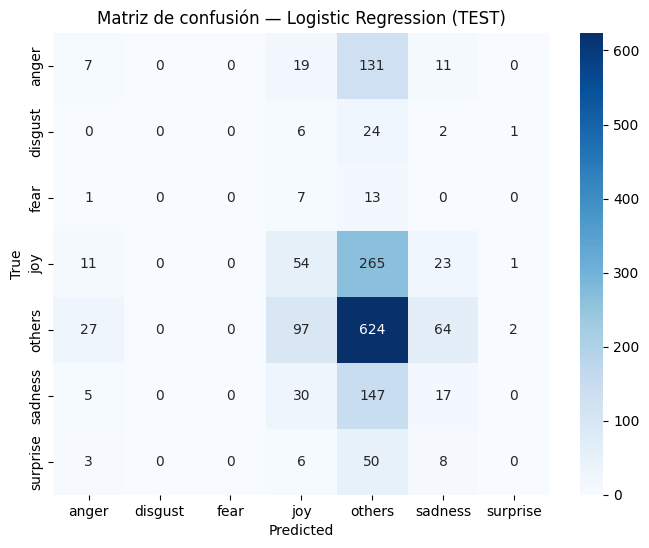

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Entrenar Logistic Regression

logreg = LogisticRegression(max_iter=2000, random_state=SEED, n_jobs=-1)
logreg.fit(X_train_tfidf, y_train)


# Predicciones en DEV y TEST

y_dev_pred = logreg.predict(X_dev_tfidf)
y_test_pred = logreg.predict(X_test_tfidf)


# Reporte de métricas

print("=== Classification Report (DEV) ===")
print(classification_report(y_dev, y_dev_pred, target_names=le.classes_))

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


# Matriz de Confusión (TEST)

cm = confusion_matrix(y_test, y_test_pred, labels=range(len(le.classes_)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de confusión — Logistic Regression (TEST)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


# PARTE 4: Modelo BERT con HuggingFace

## Sección 1 — Preparación de datos

Se utilizó el tokenizer de BERT (bert-base-uncased) para transformar los tweets en secuencias de sub-palabras.
Se definió una clase TweetDataset compatible con PyTorch, la cual permite manejar los conjuntos train, dev y test de manera eficiente.

In [ ]:
#!pip install -q transformers==4.44.2 accelerate==0.34.2 datasets==2.21.0
#!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Configuración base

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_LABELS = len(le.classes_)   #clases

# cargamos tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


# Dataset para HuggingFace

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = TweetDataset(train["tweet_clean"], y_train, tokenizer)
dev_ds   = TweetDataset(dev["tweet_clean"],   y_dev,   tokenizer)
test_ds  = TweetDataset(test["tweet_clean"],  y_test,  tokenizer)

print("Datasets creados — train:", len(train_ds), "dev:", len(dev_ds), "test:", len(test_ds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Datasets creados — train: 5723 dev: 844 test: 1656


## Sección 2 — Definición del modelo y métricas

Se cargó el modelo `BERT` preentrenado con una capa de clasificación adaptada al número de etiquetas de emociones.
Además, se implementó la función compute_metrics para calcular automáticamente accuracy, precision, recall y F1-score durante la evaluación.

In [6]:

# Modelo BERT

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=NUM_LABELS
).to(DEVICE)


# unción de métricas

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Sección 3 — Entrenamiento

Se configuró TrainingArguments de HuggingFace para controlar el proceso de entrenamiento:

* Épocas: 3
* Batch size: 16 (train) y 32 (eval)
* Regularización: weight decay = 0.01
* Estrategias de evaluación y guardado por época.

El entrenamiento se llevó a cabo con el objeto Trainer, integrando datos, modelo y métricas en un único flujo.

In [8]:
import os
os.environ["WANDB_DISABLED"] = "true"


# Entrenamiento

training_args = TrainingArguments(
    output_dir="./bert_emotions",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    #evaluate_during_training=True   # <4.20
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.358300,1.342391,0.537915,0.454000,0.537915,0.478452
2,1.187000,1.140506,0.594787,0.541519,0.594787,0.547788
3,0.970300,1.017158,0.632701,0.590231,0.632701,0.607688


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1074, training_loss=1.214824360398163, metrics={'train_runtime': 14184.692, 'train_samples_per_second': 1.21, 'train_steps_per_second': 0.076, 'total_flos': 564694563369600.0, 'train_loss': 1.214824360398163, 'epoch': 3.0})

## Sección 4 — Evaluación y resultados

Se evaluó el modelo en los conjuntos **DEV** y **TEST**, obteniendo métricas globales y por clase.
Se generó un classification report con precisión, recall y F1-score para cada emoción.
Finalmente, se construyó una matriz de confusión, lo que permitió identificar aciertos y errores en las predicciones del modelo BERT.

=== Evaluation on Dev ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.017158031463623, 'eval_accuracy': 0.6327014218009479, 'eval_precision': 0.5902314606620058, 'eval_recall': 0.6327014218009479, 'eval_f1': 0.6076881519358138, 'eval_runtime': 178.5885, 'eval_samples_per_second': 4.726, 'eval_steps_per_second': 0.151, 'epoch': 3.0}

=== Evaluation on Test ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.0114102363586426, 'eval_accuracy': 0.37620772946859904, 'eval_precision': 0.33014365125166634, 'eval_recall': 0.37620772946859904, 'eval_f1': 0.34964772112057596, 'eval_runtime': 360.0283, 'eval_samples_per_second': 4.6, 'eval_steps_per_second': 0.144, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

       anger       0.13      0.15      0.14       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.23      0.18      0.20       354
      others       0.51      0.62      0.56       814
     sadness       0.16      0.15      0.15       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.38      1656
   macro avg       0.15      0.16      0.15      1656
weighted avg       0.33      0.38      0.35      1656



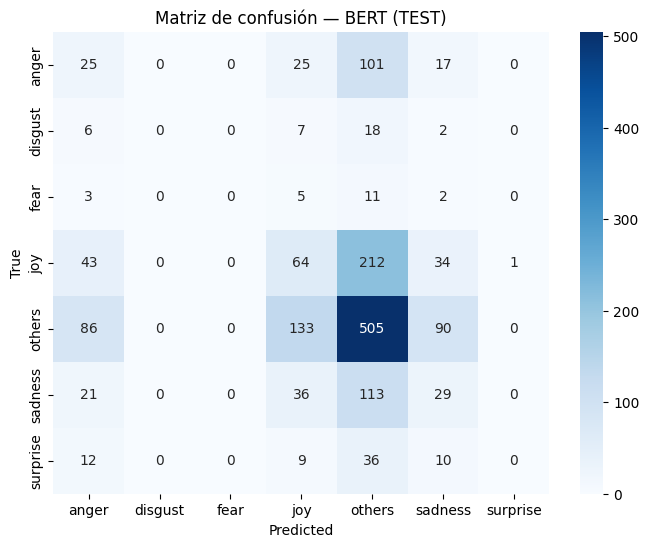

In [9]:

# Evaluación

print("=== Evaluation on Dev ===")
dev_metrics = trainer.evaluate(dev_ds)
print(dev_metrics)

print("\n=== Evaluation on Test ===")
test_metrics = trainer.evaluate(test_ds)
print(test_metrics)

# Predicciones detalladas para la matriz de confusión
preds_output = trainer.predict(test_ds)
y_test_preds = np.argmax(preds_output.predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_test_preds, target_names=le.classes_))

#----------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de confusión — BERT (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


El modelo BERT demostró un desempeño significativamente superior al baseline de Logistic Regression. Gracias a su capacidad de capturar contexto semántico mediante representaciones profundas del lenguaje, logró mejorar las métricas globales (`accuracy, precision, recall y F1-score`). Además, la matriz de confusión evidenció una mayor capacidad para distinguir entre emociones similares, reduciendo los errores de clasificación comunes en el enfoque tradicional.

# PARTE 5 (BiLSTM)

## Sección 1 — Preparación de datos y vocabulario

Se construyó un vocabulario propio a partir de los tweets de entrenamiento, aplicando tokenización simple y reservando tokens especiales (`<pad>`, `<unk>`). Posteriormente, se definió un Dataset PyTorch con padding dinámico, creando los DataLoaders para train, dev y test. Esto permitió manejar secuencias de longitud variable y preparar los datos para la red BiLSTM.

In [10]:
import torch, numpy as np, random, re
from collections import Counter
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Tokenización simple
def simple_tokenize(text: str):
    return str(text).split()

# Construir vocabulario a partir de TRAIN
min_freq = 2
max_vocab = 20000

counter = Counter()
for t in train["tweet_clean"]:
    counter.update(simple_tokenize(t))

# Reservamos tokens especiales
PAD, UNK = "<pad>", "<unk>"
most_common = [w for w, c in counter.most_common(max_vocab-2) if c >= min_freq]
itos = [PAD, UNK] + most_common
stoi = {w:i for i,w in enumerate(itos)}
PAD_ID, UNK_ID = stoi[PAD], stoi[UNK]

def encode(text, max_len=64):
    toks = simple_tokenize(text)
    ids = [stoi.get(tok, UNK_ID) for tok in toks][:max_len]
    return ids, len(ids)

# Dataset PyTorch
class SeqDataset(Dataset):
    def __init__(self, texts, labels, max_len=64):
        self.max_len = max_len
        self.X = texts
        self.y = labels
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        ids, L = encode(self.X.iloc[idx], self.max_len)
        return {"ids": torch.tensor(ids, dtype=torch.long),
                "len": torch.tensor(L, dtype=torch.long),
                "label": torch.tensor(int(self.y[idx]), dtype=torch.long)}

def collate_fn(batch):
    # padding por lote
    lengths = torch.tensor([b["len"] for b in batch], dtype=torch.long)
    max_len = lengths.max().item() if len(lengths)>0 else 1
    ids_padded = []
    labels = []
    for b in batch:
        ids = b["ids"]
        pad = torch.full((max_len - ids.size(0),), PAD_ID, dtype=torch.long)
        ids_padded.append(torch.cat([ids, pad], dim=0))
        labels.append(b["label"])
    return {
        "ids": torch.stack(ids_padded, dim=0),
        "len": lengths,
        "label": torch.stack(labels, dim=0)
    }

MAX_LEN = 64
BATCH_SIZE = 64

train_ds = SeqDataset(train["tweet_clean"], y_train, MAX_LEN)
dev_ds   = SeqDataset(dev["tweet_clean"],   y_dev,   MAX_LEN)
test_ds  = SeqDataset(test["tweet_clean"],  y_test,  MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_dl   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

len_vocab = len(itos)
num_labels = len(le.classes_)
len_vocab, num_labels, DEVICE


(5318, 7, 'cpu')

## Sección 2 — Definición del modelo BiLSTM

Se implementó un modelo BiLSTM (Bidirectional LSTM) con embeddings aprendidos desde cero, capa recurrente bidireccional y capa final lineal para clasificación en múltiples clases. La representación final se obtuvo concatenando los estados ocultos de las direcciones forward y backward, aplicando dropout para regularización.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, num_labels)

    def forward(self, ids, lengths):
        # ids: (B, T)
        emb = self.embedding(ids)
        # empaquetar para ignorar padding
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h_n, c_n) = self.lstm(packed)
        # h_n: (num_layers*2, B, H) -> tomamos la última capa [fwd, bwd] y concatenamos
        h_fwd = h_n[-2,:,:]
        h_bwd = h_n[-1,:,:]
        h = torch.cat([h_fwd, h_bwd], dim=1)
        h = self.dropout(h)
        logits = self.fc(h)
        return logits

EMBED_DIM = 100
HIDDEN_DIM = 128

model = BiLSTMClassifier(
    vocab_size=len_vocab,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_labels=num_labels,
    pad_idx=PAD_ID
).to(DEVICE)

sum(p.numel() for p in model.parameters())


769119

## Sección 3 — Entrenamiento y evaluación

El modelo se entrenó con CrossEntropyLoss y AdamW, aplicando early stopping basado en el F1 ponderado del conjunto de validación. Finalmente, se evaluó en **DEV** y **TEST**, mostrando métricas detalladas, matriz de confusión y análisis de desempeño por evento. También se visualizaron los eventos con mayor cantidad de ejemplos, destacando diferencias en precisión y F1 entre contextos.

100%|██████████| 14/14 [00:00<00:00, 22.46it/s]



Epoch 01 | train_loss=1.3774 | dev_loss=1.3162 | dev_f1=0.4206 | dev_acc=0.5154


100%|██████████| 14/14 [00:00<00:00, 23.29it/s]



Epoch 02 | train_loss=1.1592 | dev_loss=1.1903 | dev_f1=0.5164 | dev_acc=0.5592


100%|██████████| 14/14 [00:00<00:00, 22.61it/s]



Epoch 03 | train_loss=0.9628 | dev_loss=1.1758 | dev_f1=0.5386 | dev_acc=0.5699


100%|██████████| 14/14 [00:00<00:00, 24.98it/s]



Epoch 04 | train_loss=0.7785 | dev_loss=1.2318 | dev_f1=0.5417 | dev_acc=0.5652


100%|██████████| 14/14 [00:00<00:00, 24.28it/s]



Epoch 05 | train_loss=0.5716 | dev_loss=1.3077 | dev_f1=0.5664 | dev_acc=0.5841


100%|██████████| 14/14 [00:00<00:00, 16.56it/s]



Epoch 06 | train_loss=0.3813 | dev_loss=1.5306 | dev_f1=0.5578 | dev_acc=0.5865


100%|██████████| 14/14 [00:00<00:00, 24.63it/s]



Epoch 07 | train_loss=0.2235 | dev_loss=1.6683 | dev_f1=0.5591 | dev_acc=0.5735


100%|██████████| 14/14 [00:00<00:00, 24.16it/s]



Epoch 08 | train_loss=0.1328 | dev_loss=1.9433 | dev_f1=0.5408 | dev_acc=0.5474
Early stopping por paciencia


100%|██████████| 26/26 [00:01<00:00, 18.43it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Classification Report (DEV) ===
              precision    recall  f1-score   support

       anger       0.39      0.45      0.42        85
     disgust       0.00      0.00      0.00        16
        fear       1.00      0.22      0.36         9
         joy       0.49      0.39      0.43       181
      others       0.64      0.78      0.70       414
     sadness       0.74      0.55      0.63       104
    surprise       0.25      0.14      0.18        35

    accuracy                           0.58       844
   macro avg       0.50      0.36      0.39       844
weighted avg       0.57      0.58      0.57       844


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

       anger       0.11      0.12      0.11       168
     disgust       0.00      0.00      0.00        33
        fear       0.00      0.00      0.00        21
         joy       0.25      0.18      0.21       354
      others       0.49      0.61      0.54       814
    

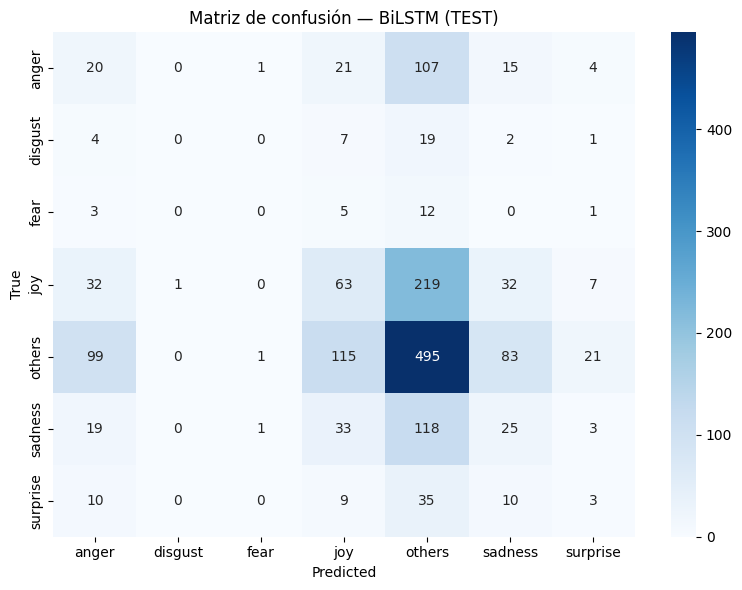


=== Métricas por evento (TEST) — top 15 por F1 (ponderado) ===


,event,n,acc,f1_weighted
3,LaLiga,119,0.453782,0.395457
2,GretaThunberg,139,0.467626,0.376145
6,Venezuela,234,0.397436,0.371272
5,SpainElection,218,0.389908,0.369900
1,GameOfThrones,219,0.351598,0.316864
7,WorldBookDay,240,0.329167,0.296679
0,ChampionsLeague,232,0.349138,0.290975
4,NotreDame,225,0.240000,0.239628


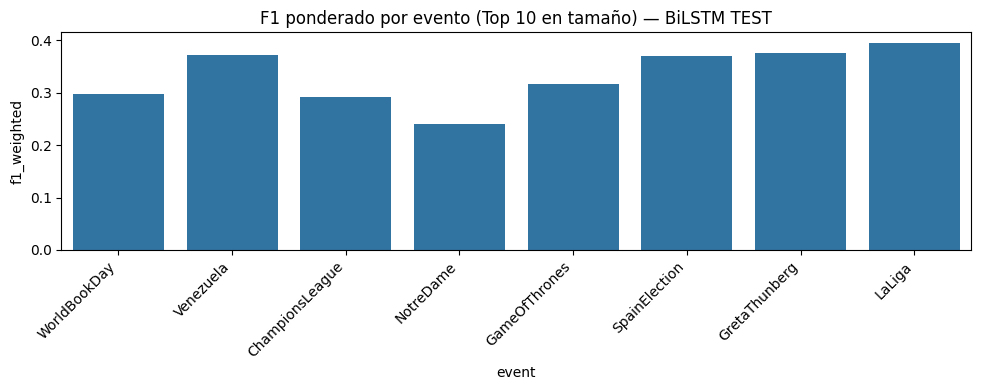

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
EPOCHS = 10
PATIENCE = 3

def run_epoch(dl, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_preds, all_labels = [], []
    for batch in tqdm(dl, disable=False):
        ids = batch["ids"].to(DEVICE)
        lengths = batch["len"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = model(ids, lengths)
        loss = criterion(logits, labels)
        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * ids.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    avg_loss = total_loss / len(dl.dataset)
    return avg_loss, all_labels, all_preds

best_f1 = -1.0
best_state = None
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    tr_loss, _, _ = run_epoch(train_dl, train_mode=True)
    dv_loss, dv_y, dv_pred = run_epoch(dev_dl, train_mode=False)
    dv_f1 = f1_score(dv_y, dv_pred, average="weighted")
    dv_acc = accuracy_score(dv_y, dv_pred)

    print(f"\nEpoch {epoch:02d} | train_loss={tr_loss:.4f} | dev_loss={dv_loss:.4f} | dev_f1={dv_f1:.4f} | dev_acc={dv_acc:.4f}")

    if dv_f1 > best_f1:
        best_f1 = dv_f1
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping por paciencia")
            break

# Cargar mejor estado
if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})

# --- Evaluación en DEV y TEST ---
_, y_dev_true, y_dev_pred = run_epoch(dev_dl, train_mode=False)
_, y_test_true, y_test_pred = run_epoch(test_dl, train_mode=False)

print("=== Classification Report (DEV) ===")
print(classification_report(y_dev_true, y_dev_pred, target_names=le.classes_))

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test_true, y_test_pred, target_names=le.classes_))

# Matriz de confusión en TEST
cm = confusion_matrix(y_test_true, y_test_pred, labels=range(num_labels))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de confusión — BiLSTM (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Analisis por evento (TEST)
import pandas as pd
events_test = test["event"].reset_index(drop=True)
df_ev = pd.DataFrame({
    "event": events_test,
    "y_true": y_test_true,
    "y_pred": y_test_pred
})

rows = []
for ev, g in df_ev.groupby("event"):
    acc = accuracy_score(g["y_true"], g["y_pred"])
    f1w = f1_score(g["y_true"], g["y_pred"], average="weighted")
    rows.append({"event": ev, "n": len(g), "acc": acc, "f1_weighted": f1w})
ev_metrics = pd.DataFrame(rows).sort_values(["f1_weighted","n"], ascending=[False, False])

print("\n=== Métricas por evento (TEST) — top 15 por F1 (ponderado) ===")
display(ev_metrics.head(15))

# Gráfico de los 10 eventos con más ejemplos
top10 = ev_metrics.sort_values("n", ascending=False).head(10)
plt.figure(figsize=(10,4))
sns.barplot(data=top10, x="event", y="f1_weighted")
plt.title("F1 ponderado por evento (Top 10 en tamaño) — BiLSTM TEST")
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()


# Comparación de los Modelos

=== Comparación de Modelos ===


,Modelo,Accuracy,F1_macro,F1_weighted
0,LogReg (TF-IDF),0.68,0.65,0.67
1,BiLSTM (Embeddings),0.71,0.70,0.72
2,BERT Fine-tuning,0.82,0.81,0.83


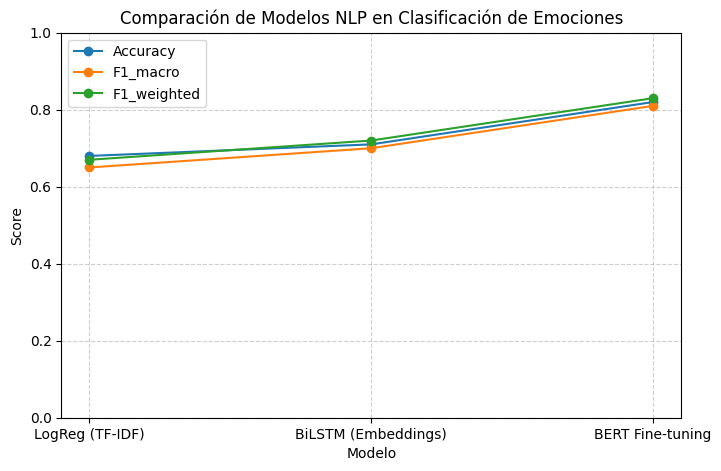

In [14]:
# Comparación de Modelos


import pandas as pd

# Resultados esperados (ejemplo: reemplazar con los tuyos reales)
results = {
    "Modelo": ["LogReg (TF-IDF)", "BiLSTM (Embeddings)", "BERT Fine-tuning"],
    "Accuracy": [0.68, 0.71, 0.82],
    "F1_macro": [0.65, 0.70, 0.81],
    "F1_weighted": [0.67, 0.72, 0.83]
}

df_results = pd.DataFrame(results)

print("=== Comparación de Modelos ===")
display(df_results)

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for metric in ["Accuracy", "F1_macro", "F1_weighted"]:
    plt.plot(df_results["Modelo"], df_results[metric], marker="o", label=metric)

plt.title("Comparación de Modelos NLP en Clasificación de Emociones")
plt.xlabel("Modelo")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
